In [ ]:
import numpy as np
from keras.datasets import fashion_mnist
def load_fashion_mnist(flatten=True, normalize=True, one_hot=True, num_classes=10):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    if flatten:
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)
    if normalize:
        x_train = x_train / 255.0
        x_test = x_test / 255.0
    if one_hot:
        y_train = np.eye(num_classes)[y_train]
        y_test = np.eye(num_classes)[y_test]
    return x_train, y_train, x_test, y_test

In [ ]:
import numpy as np
def relu(z):
    return np.maximum(0, z)
def relu_der(z):
    return (z > 0).astype(float)
def soft(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [ ]:
def ini_para(layer_sizes):
    np.random.seed(42)
    params = {}
    L = len(layer_sizes)
    for l in range(1, L):
        params['W'+str(l)] = np.random.randn(layer_sizes[l-1], layer_sizes[l]) * 0.01
        params['b'+str(l)] = np.zeros((1, layer_sizes[l]))
    return params

In [ ]:
def forward(X, params):
    cache = {'A0': X}
    L = len(params)//2
    for l in range(1, L):
        Z = np.dot(cache['A'+str(l-1)], params['W'+str(l)]) + params['b'+str(l)]
        A = relu(Z)
        cache['Z'+str(l)] = Z
        cache['A'+str(l)] = A
    ZL = np.dot(cache['A'+str(L-1)], params['W'+str(L)]) + params['b'+str(L)]
    AL = soft(ZL)
    cache['Z'+str(L)] = ZL
    cache['A'+str(L)] = AL
    return AL, cache

In [ ]:
def comp_loss(Y_pred, Y_true):
    m = Y_true.shape[0]
    loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
    return loss

In [ ]:
def backward(Y_pred, Y_true, params, cache, learning_rate=0.01):
    grads = {}
    L = len(params)//2
    m = Y_true.shape[0]
    dZ = Y_pred - Y_true
    grads['dW'+str(L)] = np.dot(cache['A'+str(L-1)].T, dZ)/m
    grads['db'+str(L)] = np.sum(dZ, axis=0, keepdims=True)/m
    dA_prev = np.dot(dZ, params['W'+str(L)].T)
    for l in reversed(range(1, L)):
        dZ = dA_prev * relu_der(cache['Z'+str(l)])
        grads['dW'+str(l)] = np.dot(cache['A'+str(l-1)].T, dZ)/m
        grads['db'+str(l)] = np.sum(dZ, axis=0, keepdims=True)/m
        if l > 1:
            dA_prev = np.dot(dZ, params['W'+str(l)].T)
    for l in range(1, L+1):
        params['W'+str(l)] -= learning_rate * grads['dW'+str(l)]
        params['b'+str(l)] -= learning_rate * grads['db'+str(l)]

In [ ]:
def train(X_train, Y_train, X_test, Y_test, hidden_layers=[128,64], lr=0.01, epochs=20):
    layer_sizes = [X_train.shape[1]] + hidden_layers + [10]
    params = ini_para(layer_sizes)
    for epoch in range(epochs):
        Y_pred, cache = forward(X_train, params)
        loss = comp_loss(Y_pred, Y_train)
        backward(Y_pred, Y_train, params, cache, learning_rate=lr)
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    Y_pred_test, _ = forward(X_test, params)
    accuracy = np.mean(np.argmax(Y_pred_test, axis=1) == np.argmax(Y_test, axis=1))
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    return params

In [ ]:
import numpy as np
from keras.datasets import fashion_mnist
def load_fashion_mnist(flatten=True, normalize=True, one_hot=True, num_classes=10):
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    if flatten:
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)
    if normalize:
        x_train = x_train / 255.0
        x_test = x_test / 255.0
    if one_hot:
        y_train = np.eye(num_classes)[y_train]
        y_test = np.eye(num_classes)[y_test]
    return x_train, y_train, x_test, y_test
class Activate:
    @staticmethod
    def relu(Z):
        return np.maximum(0, Z)
    @staticmethod
    def relu_der(Z):
        return (Z > 0).astype(float)
    @staticmethod
    def softmax(Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)
class FNN:
    def __init__(self, input_size, hidden_layers, output_size, seed=42):
        np.random.seed(seed)
        self.layers = [input_size] + hidden_layers + [output_size]
        self.L = len(self.layers) - 1
        self.weights = {}
        self.biases = {}
        for l in range(1, self.L+1):
            limit = np.sqrt(6 / (self.layers[l-1] + self.layers[l]))
            self.weights['W'+str(l)] = np.random.uniform(-limit, limit, (self.layers[l-1], self.layers[l]))
            self.biases['b'+str(l)] = np.zeros((1, self.layers[l]))
        self.opt_caches = {}
    def forward(self, X):
        self.cache = {'A0': X}
        for l in range(1, self.L):
            Z = np.dot(self.cache['A'+str(l-1)], self.weights['W'+str(l)]) + self.biases['b'+str(l)]
            A = Activate.relu(Z)
            self.cache['Z'+str(l)] = Z
            self.cache['A'+str(l)] = A
        ZL = np.dot(self.cache['A'+str(self.L-1)], self.weights['W'+str(self.L)]) + self.biases['b'+str(self.L)]
        AL = Activate.softmax(ZL)
        self.cache['Z'+str(self.L)] = ZL
        self.cache['A'+str(self.L)] = AL
        return AL
    def backward(self, Y_true):
        m = Y_true.shape[0]
        self.grads = {}
        dZ = self.cache['A'+str(self.L)] - Y_true
        self.grads['dW'+str(self.L)] = np.dot(self.cache['A'+str(self.L-1)].T, dZ)/m
        self.grads['db'+str(self.L)] = np.sum(dZ, axis=0, keepdims=True)/m
        dA_prev = np.dot(dZ, self.weights['W'+str(self.L)].T)
        for l in reversed(range(1, self.L)):
            dZ = dA_prev * Activate.relu_der(self.cache['Z'+str(l)])
            self.grads['dW'+str(l)] = np.dot(self.cache['A'+str(l-1)].T, dZ)/m
            self.grads['db'+str(l)] = np.sum(dZ, axis=0, keepdims=True)/m
            if l > 1:
                dA_prev = np.dot(dZ, self.weights['W'+str(l)].T)
    def compute_loss(self, Y_pred, Y_true):
      m = Y_true.shape[0]
      return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
    def update_parameters(self, lr=0.01, optimizer='sgd', beta1=0.9, beta2=0.999, epsilon=1e-8, t=1):
        for l in range(1, self.L+1):
            dW = self.grads['dW'+str(l)]
            db = self.grads['db'+str(l)]
            if optimizer == 'sgd':
                self.weights['W'+str(l)] -= lr * dW
                self.biases['b'+str(l)] -= lr * db
            elif optimizer == 'momentum':
                if 'vW'+str(l) not in self.opt_caches:
                    self.opt_caches['vW'+str(l)] = np.zeros_like(dW)
                    self.opt_caches['vb'+str(l)] = np.zeros_like(db)
                self.opt_caches['vW'+str(l)] = beta1*self.opt_caches['vW'+str(l)] + (1-beta1)*dW
                self.opt_caches['vb'+str(l)] = beta1*self.opt_caches['vb'+str(l)] + (1-beta1)*db
                self.weights['W'+str(l)] -= lr * self.opt_caches['vW'+str(l)]
                self.biases['b'+str(l)] -= lr * self.opt_caches['vb'+str(l)]
            elif optimizer == 'nesterov':
                if 'vW'+str(l) not in self.opt_caches:
                    self.opt_caches['vW'+str(l)] = np.zeros_like(dW)
                    self.opt_caches['vb'+str(l)] = np.zeros_like(db)
                vW_prev = self.opt_caches['vW'+str(l)].copy()
                vb_prev = self.opt_caches['vb'+str(l)].copy()
                self.opt_caches['vW'+str(l)] = beta1*self.opt_caches['vW'+str(l)] + lr*dW
                self.opt_caches['vb'+str(l)] = beta1*self.opt_caches['vb'+str(l)] + lr*db
                self.weights['W'+str(l)] -= beta1*vW_prev + (1+beta1)*(self.opt_caches['vW'+str(l)] - vW_prev)
                self.biases['b'+str(l)] -= beta1*vb_prev + (1+beta1)*(self.opt_caches['vb'+str(l)] - vb_prev)
            elif optimizer == 'rmsprop':
                if 'sW'+str(l) not in self.opt_caches:
                    self.opt_caches['sW'+str(l)] = np.zeros_like(dW)
                    self.opt_caches['sb'+str(l)] = np.zeros_like(db)
                self.opt_caches['sW'+str(l)] = beta2*self.opt_caches['sW'+str(l)] + (1-beta2)*(dW**2)
                self.opt_caches['sb'+str(l)] = beta2*self.opt_caches['sb'+str(l)] + (1-beta2)*(db**2)
                self.weights['W'+str(l)] -= lr * dW / (np.sqrt(self.opt_caches['sW'+str(l)]) + epsilon)
                self.biases['b'+str(l)] -= lr * db / (np.sqrt(self.opt_caches['sb'+str(l)]) + epsilon)
            elif optimizer == 'adam':
                if 'vW'+str(l) not in self.opt_caches:
                    self.opt_caches['vW'+str(l)] = np.zeros_like(dW)
                    self.opt_caches['vb'+str(l)] = np.zeros_like(db)
                    self.opt_caches['sW'+str(l)] = np.zeros_like(dW)
                    self.opt_caches['sb'+str(l)] = np.zeros_like(db)
                self.opt_caches['vW'+str(l)] = beta1*self.opt_caches['vW'+str(l)] + (1-beta1)*dW
                self.opt_caches['vb'+str(l)] = beta1*self.opt_caches['vb'+str(l)] + (1-beta1)*db
                self.opt_caches['sW'+str(l)] = beta2*self.opt_caches['sW'+str(l)] + (1-beta2)*(dW**2)
                self.opt_caches['sb'+str(l)] = beta2*self.opt_caches['sb'+str(l)] + (1-beta2)*(db**2)
                vW_corr = self.opt_caches['vW'+str(l)] / (1 - beta1**t)
                vb_corr = self.opt_caches['vb'+str(l)] / (1 - beta1**t)
                sW_corr = self.opt_caches['sW'+str(l)] / (1 - beta2**t)
                sb_corr = self.opt_caches['sb'+str(l)] / (1 - beta2**t)
                self.weights['W'+str(l)] -= lr * vW_corr / (np.sqrt(sW_corr) + epsilon)
                self.biases['b'+str(l)] -= lr * vb_corr / (np.sqrt(sb_corr) + epsilon)
            elif optimizer == 'nadam':
                if 'vW'+str(l) not in self.opt_caches:
                    self.opt_caches['vW'+str(l)] = np.zeros_like(dW)
                    self.opt_caches['vb'+str(l)] = np.zeros_like(db)
                    self.opt_caches['sW'+str(l)] = np.zeros_like(dW)
                    self.opt_caches['sb'+str(l)] = np.zeros_like(db)
                vW_prev = self.opt_caches['vW'+str(l)].copy()
                vb_prev = self.opt_caches['vb'+str(l)].copy()
                self.opt_caches['vW'+str(l)] = beta1*self.opt_caches['vW'+str(l)] + (1-beta1)*dW
                self.opt_caches['vb'+str(l)] = beta1*self.opt_caches['vb'+str(l)] + (1-beta1)*db
                self.opt_caches['sW'+str(l)] = beta2*self.opt_caches['sW'+str(l)] + (1-beta2)*(dW**2)
                self.opt_caches['sb'+str(l)] = beta2*self.opt_caches['sb'+str(l)] + (1-beta2)*(db**2)
                vW_corr = (beta1*vW_prev + (1+beta1)*self.opt_caches['vW'+str(l)]/(1-beta1**t)) / (1 - beta1**t)
                vb_corr = (beta1*vb_prev + (1+beta1)*self.opt_caches['vb'+str(l)]/(1-beta1**t)) / (1 - beta1**t)
                sW_corr = self.opt_caches['sW'+str(l)] / (1 - beta2**t)
                sb_corr = self.opt_caches['sb'+str(l)] / (1 - beta2**t)
                self.weights['W'+str(l)] -= lr * vW_corr / (np.sqrt(sW_corr) + epsilon)
                self.biases['b'+str(l)] -= lr * vb_corr / (np.sqrt(sb_corr) + epsilon)
    def cross_entropy_loss(Y_pred, Y_true):
        m = Y_true.shape[0]
        return -np.sum(Y_true*np.log(Y_pred + 1e-8))/m
    def train(fnn, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=64, lr=0.01, optimizer='sgd'):
        num_samples = X_train.shape[0]
        for epoch in range(epochs):
            perm = np.random.permutation(num_samples)
            X_train, Y_train = X_train[perm], Y_train[perm]
            for i in range(0, num_samples, batch_size):
                X_batch = X_train[i:i+batch_size]
                Y_batch = Y_train[i:i+batch_size]
                Y_pred = fnn.forward(X_batch)
                fnn.backward(Y_batch)
                fnn.update_parameters(lr=lr, optimizer=optimizer, t=epoch+1)
            Y_pred_epoch = fnn.forward(X_train)
            loss = cross_entropy_loss(Y_pred_epoch, Y_train)
            Y_pred_test = fnn.forward(X_test)
            acc = np.mean(np.argmax(Y_pred_test, axis=1) == np.argmax(Y_test, axis=1))
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Test Accuracy: {acc*100:.2f}%, Optimizer: {optimizer}")


In [ ]:
!pip install wandb
import wandb
wandb.login()


True

In [ ]:
perm = np.random.permutation(X_train.shape[0])
X_train, Y_train = X_train[perm], Y_train[perm]
val_size = int(0.1 * X_train.shape[0])
X_val, Y_val = X_train[:val_size], Y_train[:val_size]
X_train_s, Y_train_s = X_train[val_size:], Y_train[val_size:]

In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {
            "values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]
        },
        "batch_size": {"values": [16, 32, 64]},
    }
}


In [ ]:
def sweep_train():
    run = wandb.init()
    config = wandb.config

    # dynamic hidden layers
    hidden_layers = [config.hidden_size] * config.num_layers

    model = FNN(
        input_size=X_train_s.shape[1],
        hidden_layers=hidden_layers,
        output_size=10
    )

    run.name = f"hl_{config.num_layers}_bs_{config.batch_size}_opt_{config.optimizer}"

    for epoch in range(config.epochs):
        perm = np.random.permutation(X_train_s.shape[0])
        X_shuf, Y_shuf = X_train_s[perm], Y_train_s[perm]

        for i in range(0, X_shuf.shape[0], config.batch_size):
            xb = X_shuf[i:i+config.batch_size]
            yb = Y_shuf[i:i+config.batch_size]

            preds = model.forward(xb)
            model.backward(yb)
            model.update_parameters(
                lr=config.learning_rate,
                optimizer=config.optimizer,
                t=epoch+1
            )
        train_preds = model.forward(X_train_s)
        train_loss = model.compute_loss(train_preds, Y_train_s)
        train_acc = np.mean(
        np.argmax(train_preds, axis=1) == np.argmax(Y_train_s, axis=1)
        )


        # validation
        val_preds = model.forward(X_val)
        val_loss = model.compute_loss(val_preds, Y_val)
        val_acc = np.mean(
        np.argmax(val_preds, axis=1) == np.argmax(Y_val, axis=1)
        )

        wandb.log({
            "epoch": epoch,
            "loss": train_loss,
            "accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-q4")
wandb.agent(sweep_id, function=sweep_train, count=20)


Create sweep with ID: ve1xrh6i
Sweep URL: https://wandb.ai/vaishalinir-ymc2022-chennai-institute-of-technology/fashion-mnist-q4/sweeps/ve1xrh6i


wandb: Agent Starting Run: sf1etgph with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▃▂▁▁
accuracy,0.78817
epoch,4
loss,0.63357
val_accuracy,0.79183
val_loss,0.63306


wandb: Agent Starting Run: ru3nv9s6 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▅▃▂▁
accuracy,0.7423
epoch,4
loss,0.78281
val_accuracy,0.74833
val_loss,0.7794


wandb: Agent Starting Run: pw5ek5jc with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▄▆▇█
val_loss,█▃▂▁▁
accuracy,0.76778
epoch,4
loss,0.64595
val_accuracy,0.76833
val_loss,0.64503


wandb: Agent Starting Run: jb170sm2 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,0.81781
epoch,9
loss,0.51716
val_accuracy,0.81667
val_loss,0.52631


wandb: Agent Starting Run: vm0biq9n with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇█▇
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,0.9015
epoch,9
loss,0.26507
val_accuracy,0.8865
val_loss,0.30493


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7fc88mny with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇█▇
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,0.9015
epoch,9
loss,0.26507
val_accuracy,0.8865
val_loss,0.30493


wandb: Agent Starting Run: njm9u980 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▅▆▇▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
accuracy,0.90546
epoch,9
loss,0.25621
val_accuracy,0.8895
val_loss,0.3017


wandb: Agent Starting Run: j4lkw6f9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▃▆▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▃▆▆▆█▇▇██
val_loss,█▆▃▃▃▂▂▁▁▁
accuracy,0.86767
epoch,9
loss,0.3646
val_accuracy,0.865
val_loss,0.38116


wandb: Agent Starting Run: aqqr8804 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▅▆██
epoch,▁▃▅▆█
loss,█▄▃▁▁
val_accuracy,▁▆▆██
val_loss,█▄▃▂▁
accuracy,0.86576
epoch,4
loss,0.37551
val_accuracy,0.8605
val_loss,0.39162


wandb: Agent Starting Run: bqe9g7uy with config:
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▆▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▂▂▁▁
val_accuracy,▁▃▅▅▆▇▆▆█▇
val_loss,█▅▃▂▂▂▂▂▁▁
accuracy,0.88833
epoch,9
loss,0.30794
val_accuracy,0.882
val_loss,0.334


wandb: Agent Starting Run: kgybhh16 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇██
val_loss,█▄▃▂▂▂▂▁▁▁
accuracy,0.90141
epoch,9
loss,0.26867
val_accuracy,0.88717
val_loss,0.3139


wandb: Agent Starting Run: 93jwl8qt with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▆▅▇▇▇▇█▇█
val_loss,█▄▄▃▃▃▂▁▁▁
accuracy,0.88181
epoch,9
loss,0.32348
val_accuracy,0.876
val_loss,0.34686


wandb: Agent Starting Run: qw2ramjb with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▄▆▇▇████▇
val_loss,█▄▃▂▂▁▁▁▁▁
accuracy,0.91098
epoch,9
loss,0.23785
val_accuracy,0.888
val_loss,0.31299


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: um9vn0eh with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▅▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇█▇█▇█
val_loss,█▄▃▂▂▁▂▁▁▁
accuracy,0.87276
epoch,9
loss,0.34931
val_accuracy,0.8625
val_loss,0.39671


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v7bgr19w with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▃▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▂▅▆▇▇▇███
val_loss,█▆▃▃▂▂▁▁▁▁
accuracy,0.87809
epoch,9
loss,0.34075
val_accuracy,0.87383
val_loss,0.36069


wandb: Agent Starting Run: q5po5bvo with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▂▁▁
val_accuracy,▁▄▆▇▇████▇
val_loss,█▄▃▂▂▁▁▁▁▁
accuracy,0.91098
epoch,9
loss,0.23785
val_accuracy,0.888
val_loss,0.31299


wandb: Agent Starting Run: gp09vfdb with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▅▇▆█████
val_loss,█▄▃▂▃▂▁▁▁▁
accuracy,0.89813
epoch,9
loss,0.27464
val_accuracy,0.88533
val_loss,0.3212


wandb: Agent Starting Run: a97u211p with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁
accuracy,0.90907
epoch,9
loss,0.24316
val_accuracy,0.89017
val_loss,0.30485


wandb: Agent Starting Run: fin3bsr8 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▆▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▃▂▂▁▂▁▁
val_accuracy,▁▄▅▆▇▆████
val_loss,█▅▃▂▂▁▁▁▁▁
accuracy,0.87304
epoch,9
loss,0.35144
val_accuracy,0.86017
val_loss,0.39949


wandb: Agent Starting Run: vmxa2xo7 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.


accuracy,▁▄▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▁▁▁▁
val_accuracy,▁▄▇▇▇▇▇███
val_loss,█▄▂▂▂▁▁▁▁▁
accuracy,0.86183
epoch,9
loss,0.38657
val_accuracy,0.8505
val_loss,0.43473


In [ ]:
import wandb
wandb.init(project="fashion-mnist-q7")
X_train, Y_train, X_test, Y_test = load_fashion_mnist()
BEST_CONFIG = {
    "num_layers": 5,
    "hidden_size": 130,
    "batch_size": 65,
    "learning_rate": 0.001,
    "optimizer": "nadam",
    "epochs": 10
}
hidden_layers = [BEST_CONFIG["hidden_size"]] * BEST_CONFIG["num_layers"]
model = FNN(
    input_size=X_train.shape[1],
    hidden_layers=hidden_layers,
    output_size=10
)
for epoch in range(BEST_CONFIG["epochs"]):
    perm = np.random.permutation(X_train.shape[0])
    X_shuf, Y_shuf = X_train[perm], Y_train[perm]
    for i in range(0, X_shuf.shape[0], BEST_CONFIG["batch_size"]):
        xb = X_shuf[i:i+BEST_CONFIG["batch_size"]]
        yb = Y_shuf[i:i+BEST_CONFIG["batch_size"]]
        preds = model.forward(xb)
        model.backward(yb)
        model.update_parameters(
            lr=BEST_CONFIG["learning_rate"],
            optimizer=BEST_CONFIG["optimizer"],
            t=epoch+1
        )
Y_pred_test = model.forward(X_test)
y_pred = np.argmax(Y_pred_test, axis=1)
y_true = np.argmax(Y_test, axis=1)
test_accuracy = np.mean(y_pred == y_true)
wandb.log({"test_accuracy": test_accuracy})
print(f"Test Accuracy (Best Model): {test_accuracy:.4f}")

Test Accuracy (Best Model): 0.8489


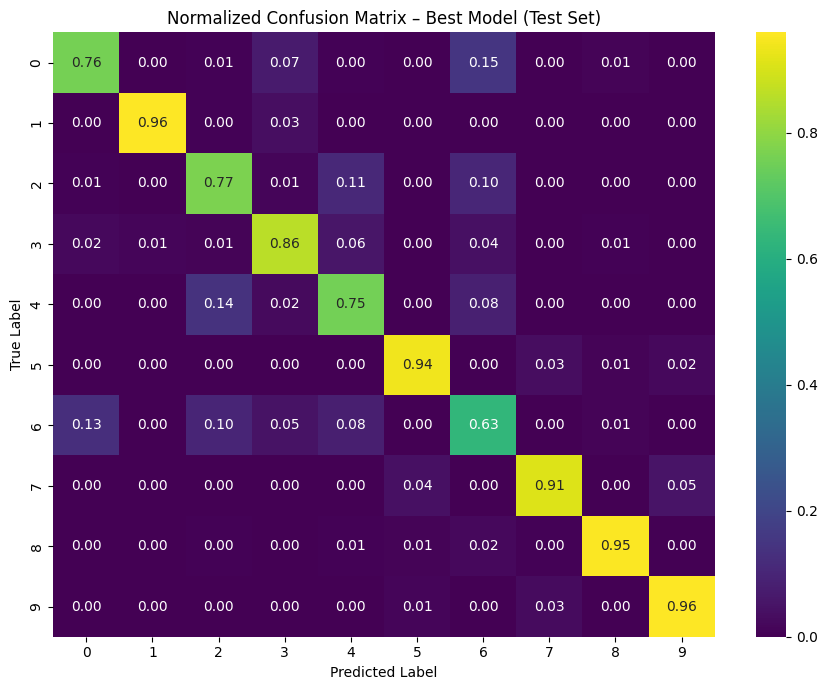

test_accuracy,▁
test_accuracy,0.8489


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(9,7))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=range(10),
    yticklabels=range(10)
)
plt.title("Normalized Confusion Matrix – Best Model (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()
wandb.finish()


-----------------------------------------------------------------------------------------------
